# Data Tour to Boston and Seattle..!!

## CRISP-DM Process
### Business Understanding:
From the datasets we can get a better knowledge how we can set the rental price for peroperties and figure out some interesting differences between Boston and Seattle Airbnb. Three business aspect questions were asked before diving into the dataset:

* Is there any noticeable difference between Seattle and Boston Airbnb?
* What are the important features to estimate rental price for Airbnb?
* Which type of services are most used by costumers?

### Data Understanding：
Boston dataset consists of 3845 listings while Seattle's has 7505 listings. Datasets were investigated before any preprocessing.

### Prepare Data:
Including data cleaning, filling NAN value,creating dummy columns for categorical values. Please refer to Preprocessing for detail.

### Data Modeling:
Used GridSearch with 5 folds validation to find best parameter for GradientBoostingRegressor. Some other models are trained and compared as well beforehand. Please refer to Training for detail.

### Evaluate the Results:
Result and discussion are published in 

# Importing all necessary files and libraries

In [74]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

Boston_listing = pd.read_csv('Boston_listings.csv')
Seattle_listing= pd.read_csv('Seattle_listings.csv')

# Data Understanding

In [75]:
# Boston_listing.head()
# Boston_listing.describe()

In [76]:
# Seattle_listing.head()
# Seattle_listing.describe()

In [77]:
def find_null(df):
    pd.DataFrame(df.isna().sum()).plot(kind='bar')

In [78]:
def plot_univariate(df,column):
    gen_order=df[column].value_counts().index
    sns.countplot(data=df,x=column,color='blue',order=gen_order)
    plt.xticks(rotation='vertical')

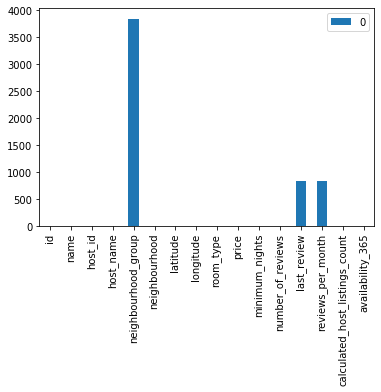

In [79]:
find_null(Boston_listing)

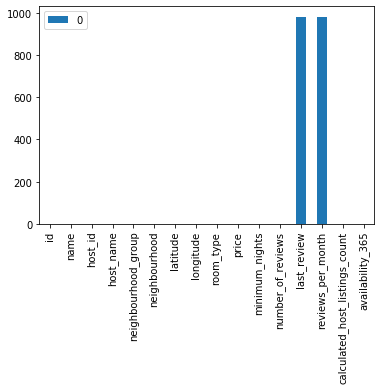

In [80]:
find_null(Seattle_listing)

Text(0.5, 1.0, 'Boston')

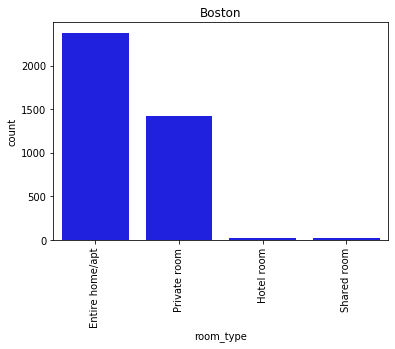

In [81]:
# Analysis based on room_type
plot_univariate(Boston_listing,'room_type')
plt.title('Boston')

Text(0.5, 1.0, 'Seattle')

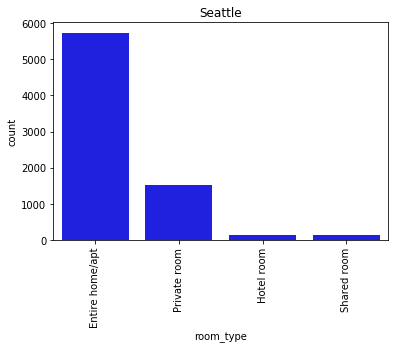

In [82]:
# Analysis based on room_type
plot_univariate(Seattle_listing,'room_type')
plt.title('Seattle')

# Data Preparation

In [83]:
Boston_listing['room_type'] = Boston_listing['room_type'].replace( ' ','_', regex=True )

In [84]:
def create_dummy_df(df, cat_cols):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
    '''
    for col in  cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], drop_first=True, dummy_na=False)], axis=1)
    return df

In [85]:
def Preprocessing(df):
    '''
    INPUT:
    df- pandas Dataframe to be preprocessed.
    
    OUTPUT:
    new_df- pandas Dataframe after cleaning and making dummies.
    '''
    # Remove unwanted columns
    df.drop(['id','name','host_id','host_name','neighbourhood_group','neighbourhood','last_review','reviews_per_month','calculated_host_listings_count'],axis=1,inplace=True)
    
    #Drop part of the columns with high ratio of missing data
    ''' null_list = df.isnull().sum()
        null_per = null_list / len(df) * 100
        drop_index = null_per[null_per > 20].index
        df.drop(drop_index, axis = 1, inplace = True)'''
    
    #drop rows for price>600
    drop_price_index = df[df.price > 600].index
    df.drop(drop_price_index, axis = 0, inplace = True)
    
    #makes amendments in room_type entities
    df['room_type'] = df['room_type'].replace( ' ','_', regex=True )
    
    #makes dummy columns for categorical values
    cat_df = df.select_dtypes(include=['object'])
    cat_cols_lst = cat_df.columns
    new_df=create_dummy_df(df, cat_cols_lst)
    
    
    return new_df

In [86]:
# Cleaning and Preprocessing of Data

Boston_listing_clean=Preprocessing(Boston_listing)
Seattle_listing_clean=Preprocessing(Seattle_listing)

## After Preprocessing checking and analysis of data 

Text(0.5, 1.0, 'Boston')

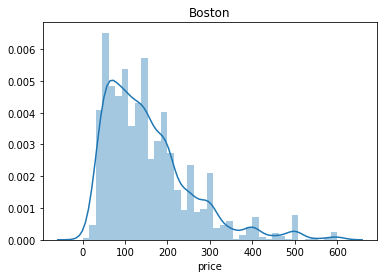

In [87]:
sns.distplot(Boston_listing_clean.price)
plt.title('Boston')

Text(0.5, 1.0, 'Seattle')

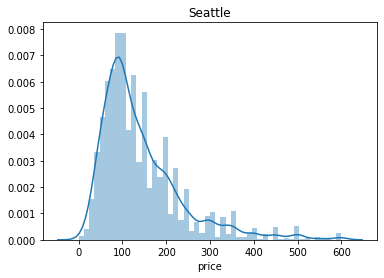

In [88]:
sns.distplot(Seattle_listing_clean.price)
plt.title('Seattle')

In [89]:
Boston_listing_clean.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,Hotel_room,Private_room,Shared_room
0,42.36413,-71.02991,125,28,16,97,0,0,0
1,42.32981,-71.09559,145,3,106,307,0,0,0
2,42.32994,-71.09351,169,3,115,266,0,0,0
3,42.35919,-71.06265,99,91,24,290,0,0,0
4,42.35840,-71.06185,150,91,31,42,0,0,0


In [90]:
Seattle_listing_clean.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,availability_365,Hotel_room,Private_room,Shared_room
0,47.61082,-122.29082,296,7,32,86,0,0,0
1,47.65411,-122.33761,90,30,150,45,0,0,0
2,47.55017,-122.31937,62,2,148,365,0,1,0
3,47.61265,-122.32936,79,3,466,10,0,1,0
4,47.55539,-122.38474,165,3,40,276,0,0,0


In [91]:
Boston_listing_clean.shape

(3780, 9)

# Model

In [92]:
def training(df):
    '''
    input:
        df: The preprocessed (Cleaning, Filling Missing data, One-hot encoding, MinMax transform) listings.
    output:
        None
    '''
    y=df.price
    X=df.drop(['price'],axis=1,inplace=False)
    
    # Split the preprocessed dataset into train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    # Grid Search to find Best Parameter
    param_grid = {'n_estimators': [400], 
                  'learning_rate': [0.05],
                  'max_depth': [10],
                  'min_samples_split': [5],
                  'subsample': [0.7]
                 }

    forest_reg = GradientBoostingRegressor(random_state = 42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    y_pred = grid_search.predict(X_test)
    print("The r-squared score for the model{} on {} values.".format(r2_score(y_test, y_pred), len(y_test)))

In [93]:
training(Boston_listing_clean)
training(Seattle_listing_clean)

Training set has 2646 samples.
Testing set has 1134 samples.
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
73.0475696052787 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
The r-squared score for the model0.5173907421477786 on 1134 values.
Training set has 5140 samples.
Testing set has 2204 samples.
{'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
79.42781956919531 {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 0.7}
The r-squared score for the model0.2954652996237179 on 2204 values.
